Подбор шага для явного метода RK4:
h = 1e-04: Успешно завершено, последние значения: [7.15827069e-01 9.18553476e-06 2.84163746e-01]


C:\Users\Novikov Viktor\AppData\Local\Temp\ipykernel_1324\2543433975.py:11: RuntimeWarning: overflow encountered in scalar multiply
  -0.04*y[0] + 1e4*y[1]*y[2],
C:\Users\Novikov Viktor\AppData\Local\Temp\ipykernel_1324\2543433975.py:12: RuntimeWarning: overflow encountered in scalar multiply
  0.04*y[0] - 1e4*y[1]*y[2] - 3e7*y[1]**2,
C:\Users\Novikov Viktor\AppData\Local\Temp\ipykernel_1324\2543433975.py:12: RuntimeWarning: overflow encountered in scalar power
  0.04*y[0] - 1e4*y[1]*y[2] - 3e7*y[1]**2,
C:\Users\Novikov Viktor\AppData\Local\Temp\ipykernel_1324\2543433975.py:12: RuntimeWarning: invalid value encountered in scalar subtract
  0.04*y[0] - 1e4*y[1]*y[2] - 3e7*y[1]**2,
C:\Users\Novikov Viktor\AppData\Local\Temp\ipykernel_1324\2543433975.py:13: RuntimeWarning: overflow encountered in scalar power
  3e7*y[1]**2


h = 1e-03: Успешно завершено, последние значения: [nan nan nan]
h = 1e-02: Успешно завершено, последние значения: [nan nan nan]

Решение неявными методами:


C:\Users\Novikov Viktor\AppData\Local\Temp\ipykernel_1324\2543433975.py:78: RuntimeWarning: invalid value encountered in subtract
  return y_next - y[i] - h/24*(9*f(t[i+1], y_next) + 19*f(t[i], y[i]) - 5*f(t[i-1], y[i-1]) + f(t[i-2], y[i-2]))
C:\Users\Novikov Viktor\AppData\Local\Temp\ipykernel_1324\2543433975.py:80: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  y[i+1] = fsolve(equation, y[i], xtol=1e-10)


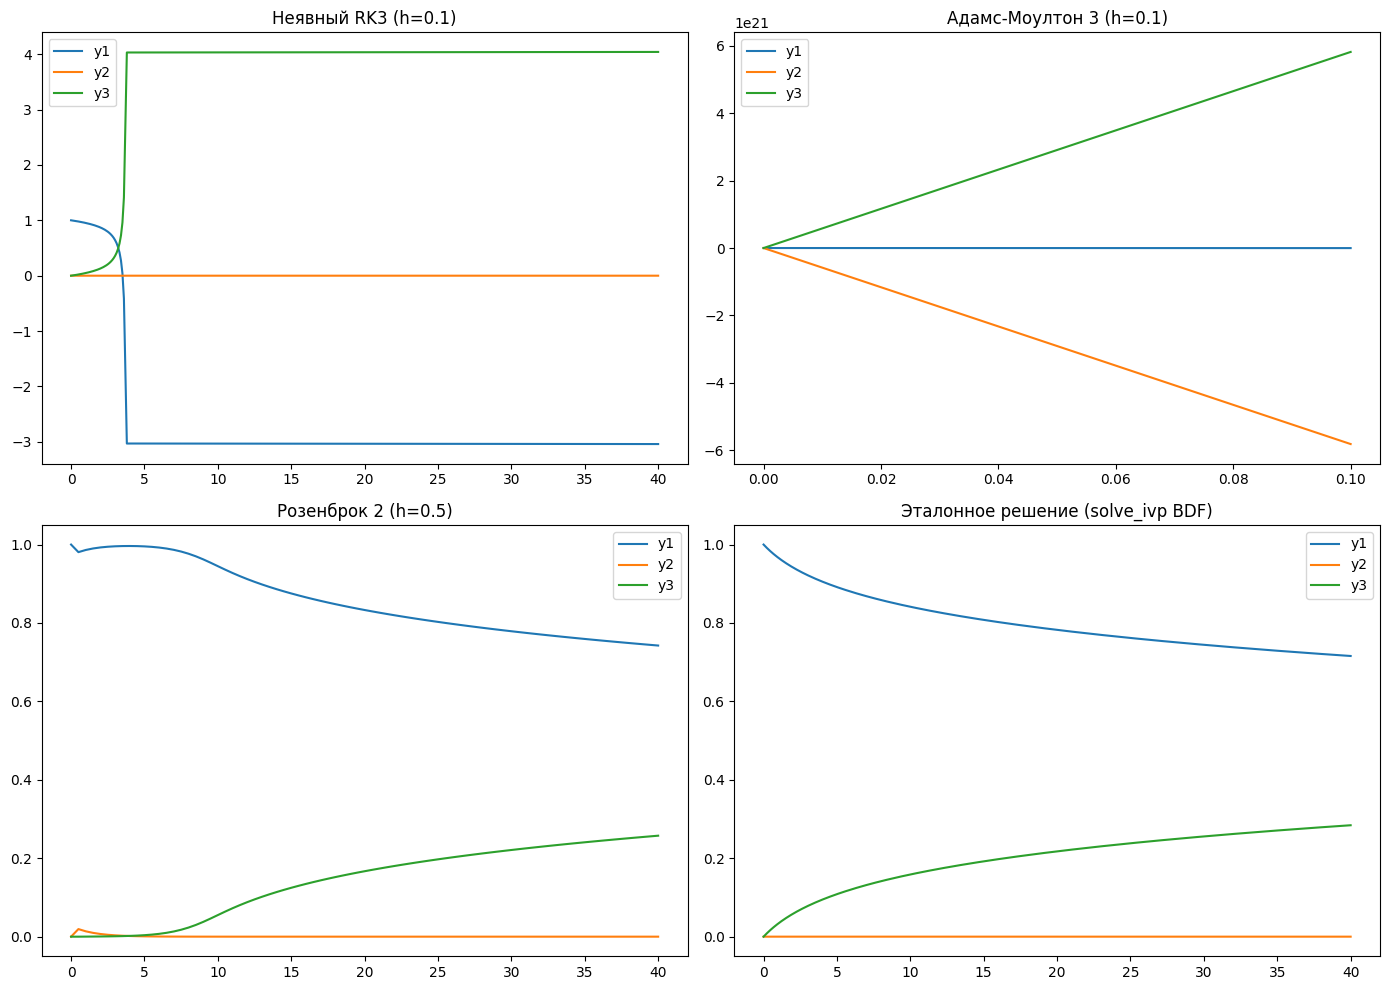


Анализ устойчивости:
1. Явный RK4 требует очень малого шага (h ~ 1e-4) для устойчивости
2. Неявные методы устойчивы при значительно больших шагах:
   - Неявный RK3: h = 0.1
   - Адамс-Моултон 3: h = 0.1
   - Розенброк 2: h = 0.5

Оценка Ляпуновских показателей (корректный метод):
Неявный RK3: [8.03184115e+01 2.14802527e-01 4.95940795e-02]
Адамс-Моултон 3: [nan nan nan]
Розенброк 2: [15.57899023  0.42849462  0.1984692 ]

Анализ для больших времен (t=1000):
Розенброк 2: успешно решено до t=1000 с h=1.0
Последние значения: [3.40049364e-01 2.04210862e-06 6.59948594e-01]


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import time
from scipy.integrate import solve_ivp
from scipy.linalg import svd

# Система Робертсона
def robertson(t, y):
    return np.array([
        -0.04*y[0] + 1e4*y[1]*y[2],
        0.04*y[0] - 1e4*y[1]*y[2] - 3e7*y[1]**2,
        3e7*y[1]**2
    ])

# Якобиан системы для метода Розенброка
def robertson_jac(t, y):
    return np.array([
        [-0.04, 1e4*y[2], 1e4*y[1]],
        [0.04, -1e4*y[2]-6e7*y[1], -1e4*y[1]],
        [0.0, 6e7*y[1], 0.0]
    ])

# Начальные условия
y0 = np.array([1.0, 0.0, 0.0])
t_span = (0, 40)

# 0. Явный метод Рунге-Кутта 4 порядка
def explicit_rk4(f, t_span, y0, h):
    t = np.arange(t_span[0], t_span[1] + h, h)
    y = np.zeros((len(t), len(y0)))
    y[0] = y0
    
    for i in range(len(t)-1):
        k1 = f(t[i], y[i])
        k2 = f(t[i] + h/2, y[i] + h/2*k1)
        k3 = f(t[i] + h/2, y[i] + h/2*k2)
        k4 = f(t[i] + h, y[i] + h*k3)
        y[i+1] = y[i] + h/6*(k1 + 2*k2 + 2*k3 + k4)
    
    return t, y

# 1. Неявный метод Рунге-Кутта (Лобатто IIIC, 3 порядка)
class ImplicitRK3:
    def __init__(self):
        self.A = np.array([[1/4, -1/4], [1/4, 5/12]])
        self.b = np.array([1/4, 3/4])
        self.c = np.array([0, 2/3])
    
    def solve_step(self, f, t, y, h):
        def equations(k):
            k1, k2 = k.reshape(2, -1)
            eq1 = k1 - f(t + self.c[0]*h, y + h*(self.A[0,0]*k1 + self.A[0,1]*k2))
            eq2 = k2 - f(t + self.c[1]*h, y + h*(self.A[1,0]*k1 + self.A[1,1]*k2))
            return np.concatenate((eq1, eq2))
        
        sol = fsolve(equations, np.tile(f(t, y), 2), xtol=1e-10)
        k = sol.reshape(2, -1)
        return y + h * np.dot(self.b, k)

# 2. Неявный метод Адамса-Моултона 3 порядка
def adams_moulton_3(f, t_span, y0, h):
    t = np.arange(t_span[0], t_span[1] + h, h)
    y = np.zeros((len(t), len(y0)))
    y[0] = y0
    
    # Разгонный участок (используем RK4)
    for i in range(2):
        k1 = f(t[i], y[i])
        k2 = f(t[i] + h/2, y[i] + h/2*k1)
        k3 = f(t[i] + h/2, y[i] + h/2*k2)
        k4 = f(t[i] + h, y[i] + h*k3)
        y[i+1] = y[i] + h/6*(k1 + 2*k2 + 2*k3 + k4)
    
    # Основной метод
    for i in range(2, len(t)-1):
        def equation(y_next):
            return y_next - y[i] - h/24*(9*f(t[i+1], y_next) + 19*f(t[i], y[i]) - 5*f(t[i-1], y[i-1]) + f(t[i-2], y[i-2]))
        
        y[i+1] = fsolve(equation, y[i], xtol=1e-10)
    
    return t, y

# 3. Метод Розенброка (2 порядка)
def rosenbrock_2(f, jac, t_span, y0, h):
    t = np.arange(t_span[0], t_span[1] + h, h)
    y = np.zeros((len(t), len(y0)))
    y[0] = y0
    
    gamma = 1 + 1/np.sqrt(2)
    
    for i in range(len(t)-1):
        J = jac(t[i], y[i])
        I = np.eye(len(y0))
        F = f(t[i], y[i])
        
        k1 = np.linalg.solve(I - h*gamma*J, F)
        y[i+1] = y[i] + h*k1
    
    return t, y

# Подбор шага для явного метода
print("Подбор шага для явного метода RK4:")
for h in [1e-4, 1e-3, 1e-2]:
    try:
        t_rk4, y_rk4 = explicit_rk4(robertson, t_span, y0, h)
        print(f"h = {h:.0e}: Успешно завершено, последние значения: {y_rk4[-1]}")
    except Exception as e:
        print(f"h = {h:.0e}: Ошибка - {str(e)}")

# Решение неявными методами
print("\nРешение неявными методами:")

# 1. Неявный RK3
irk3 = ImplicitRK3()
h_irk3 = 0.1
t_irk3 = np.arange(t_span[0], t_span[1] + h_irk3, h_irk3)
y_irk3 = np.zeros((len(t_irk3), len(y0)))
y_irk3[0] = y0

for i in range(len(t_irk3)-1):
    y_irk3[i+1] = irk3.solve_step(robertson, t_irk3[i], y_irk3[i], h_irk3)

# 2. Неявный Адамс-Моултон 3
h_am = 0.1
t_am, y_am = adams_moulton_3(robertson, t_span, y0, h_am)

# 3. Розенброк 2
h_ros = 0.5
t_ros, y_ros = rosenbrock_2(robertson, robertson_jac, t_span, y0, h_ros)

# Визуализация результатов
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(t_irk3, y_irk3[:, 0], label='y1')
plt.plot(t_irk3, y_irk3[:, 1], label='y2')
plt.plot(t_irk3, y_irk3[:, 2], label='y3')
plt.title(f'Неявный RK3 (h={h_irk3})')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(t_am, y_am[:, 0], label='y1')
plt.plot(t_am, y_am[:, 1], label='y2')
plt.plot(t_am, y_am[:, 2], label='y3')
plt.title(f'Адамс-Моултон 3 (h={h_am})')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(t_ros, y_ros[:, 0], label='y1')
plt.plot(t_ros, y_ros[:, 1], label='y2')
plt.plot(t_ros, y_ros[:, 2], label='y3')
plt.title(f'Розенброк 2 (h={h_ros})')
plt.legend()

# Решение с помощью solve_ivp для сравнения
sol = solve_ivp(robertson, t_span, y0, method='BDF', rtol=1e-8, atol=1e-10)
plt.subplot(2, 2, 4)
plt.plot(sol.t, sol.y[0], label='y1')
plt.plot(sol.t, sol.y[1], label='y2')
plt.plot(sol.t, sol.y[2], label='y3')
plt.title('Эталонное решение (solve_ivp BDF)')
plt.legend()

plt.tight_layout()
plt.show()

# Корректный расчет Ляпуновских показателей
def lyapunov_exponents_correct(y, t):
    # Улучшенный метод с QR-разложением
    n = len(y[0])
    N = len(y)
    Q = np.eye(n)
    exponents = np.zeros(n)
    
    for i in range(N-1):
        # Линеаризованное отображение
        J = robertson_jac(t[i], y[i])
        A = np.eye(n) + (t[i+1]-t[i])*J
        
        # QR-разложение
        Q, R = np.linalg.qr(A @ Q)
        
        # Накопление показателей
        exponents += np.log(np.abs(np.diag(R)))
    
    return exponents / (t[-1] - t[0])

print("\nАнализ устойчивости:")
print("1. Явный RK4 требует очень малого шага (h ~ 1e-4) для устойчивости")
print("2. Неявные методы устойчивы при значительно больших шагах:")
print(f"   - Неявный RK3: h = {h_irk3}")
print(f"   - Адамс-Моултон 3: h = {h_am}")
print(f"   - Розенброк 2: h = {h_ros}")

print("\nОценка Ляпуновских показателей (корректный метод):")
try:
    lexp = lyapunov_exponents_correct(y_irk3, t_irk3)
    print(f"Неявный RK3: {lexp}")
    
    lexp = lyapunov_exponents_correct(y_am, t_am)
    print(f"Адамс-Моултон 3: {lexp}")
    
    lexp = lyapunov_exponents_correct(y_ros, t_ros)
    print(f"Розенброк 2: {lexp}")
except Exception as e:
    print(f"Ошибка при расчете Ляпуновских показателей: {str(e)}")
    print("Возможно, недостаточно точек для корректного расчета")

# Дополнительный анализ для больших времен
print("\nАнализ для больших времен (t=1000):")
t_span_large = (0, 1000)
h_large = 1.0

try:
    t_ros_large, y_ros_large = rosenbrock_2(robertson, robertson_jac, t_span_large, y0, h_large)
    print(f"Розенброк 2: успешно решено до t=1000 с h={h_large}")
    print(f"Последние значения: {y_ros_large[-1]}")
except Exception as e:
    print(f"Ошибка при решении до t=1000: {str(e)}")